# Análise de POS Tagging com BERT

Este trabalho implementa um sistema completo de POS Tagging (Classificação Gramatical de Palavras) utilizando o modelo BERT e o corpus disponibilizado pelo Hugging Face. O POS Tagging é uma tarefa fundamental no processamento de linguagem natural que consiste em atribuir a cada palavra em um texto sua respectiva categoria gramatical, como substantivo, verbo, adjetivo, entre outras. A importância desta tarefa reside em sua utilidade como etapa prévia para diversas aplicações de NLP, incluindo análise sintática, tradução automática e sistemas de perguntas e respostas.

O objetivo principal é desenvolver um modelo capaz de classificar palavras em suas categorias gramaticais com alta precisão, utilizando uma arquitetura recente baseada em transformers. Além disso, busca-se compreender quais classes gramaticais apresentam maior ou menor dificuldade de classificação, analisando os padrões de erro e o desempenho diferencial do modelo across diferentes categorias linguísticas.

## Metodologia

A metodologia adotada segue uma pipeline convencional de projetos de machine learning, começando pelo carregamento e exploração dos dados. O dataset utilizado é o "batterydata/pos_tagging" do Hugging Face, que contém textos anotados com tags gramaticais em seus conjuntos de treino, validação e teste. Durante a fase de exploração, realizamos uma análise estatística das tags presentes no corpus, identificando a frequência de cada categoria gramatical e a distribuição geral dos dados.

Para o pré-processamento, utilizamos o tokenizer do BERT base uncased, que é responsável por dividir o texto em tokens compatíveis com o modelo. Um desafio específico do POS Tagging com modelos baseados em subpalavras é o alinhamento entre as labels originais (que correspondem a palavras inteiras) e os tokens gerados pelo tokenizer (que podem quebrar palavras em subpartes). Implementamos uma estratégia onde apenas o primeiro token de cada palavra recebe a label correspondente, enquanto tokens subsequentes da mesma palavra recebem um valor especial (-100) indicando que devem ser ignorados no cálculo da loss.

## Etapas

1. Carregamento e exploração do dataset
2. Pré-processamento dos dados
3. Implementação do modelo BERT para POS Tagging
4. Treinamento e avaliação do modelo
5. Análise dos resultados por classe gramatical

In [ ]:

# Importar todas as bibliotecas necessárias
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import load_dataset, DatasetDict
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import torch
import json

# Verificar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

/home/glauber/ai-postaging-pln/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dispositivo: cuda


## 1. Carregamento e Exploração do Dataset

Na etapa de Carregamento e Exploração do Dataset, foi utilizado o conjunto de dados Universal Dependencies English EWT (English Web Treebank) disponibilizado pela plataforma Hugging Face, composto por textos diversos da web anotados com tags gramaticais universais (UPOS). Durante esta fase, realizou-se uma análise detalhada da estrutura do dataset, identificando a existência de 17 categorias gramaticais padronizadas como ADJ (adjetivos), NOUN (substantivos), VERB (verbos) e DET (determinantes), entre outras. A exploração incluiu a verificação da distribuição dos dados entre os conjuntos de treinamento, validação e teste, bem como a análise estatística das frequências de cada classe gramatical, observando-se que substantivos (NOUN), verbos (VERB) e pontuações (PUNCT) predominavam no corpus, enquanto categorias como interjeições (INTJ) e símbolos (SYM) apresentavam menor ocorrência, o que posteriormente se refletiria no desempenho diferencial do modelo.

In [ ]:
# Carregar dataset - usar Universal Dependencies para garantir compatibilidade
print("Carregando dataset...")
try:
    dataset = load_dataset("universal_dependencies", "en_ewt")
    print("✅ Dataset Universal Dependencies carregado")
except:
    # Fallback para dataset local se online falhar
    print("Usando dataset local...")
    from datasets import Dataset, DatasetDict
    # Dados de exemplo
    train_data = {
        'tokens': [
            ['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.'],
            ['This', 'is', 'a', 'simple', 'example', 'sentence', '.']
        ],
        'upos': [
            ['DET', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'],
            ['DET', 'AUX', 'DET', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']
        ]
    }
    dataset = DatasetDict({
        'train': Dataset.from_dict(train_data),
        'validation': Dataset.from_dict(train_data),
        'test': Dataset.from_dict(train_data)
    })

# Definir colunas
token_column = 'tokens'
tag_column = 'upos'

print(f"Dataset carregado: {dataset}")

# %%
# Explorar o dataset
print("\nExplorando dataset:")
for split in dataset.keys():
    print(f"{split}: {len(dataset[split])} exemplos")
    if len(dataset[split]) > 0:
        print(f"  Primeiro exemplo:")
        print(f"    Tokens: {dataset[split][0][token_column]}")
        print(f"    Tags: {dataset[split][0][tag_column]}")

# %%
# Criar mapeamento de tags
def create_tag_mapping(dataset, tag_column):
    all_tags = set()
    for split in dataset.keys():
        for example in dataset[split]:
            all_tags.update(example[tag_column])
    
    tag2id = {tag: i for i, tag in enumerate(sorted(all_tags))}
    id2tag = {i: tag for tag, i in tag2id.items()}
    
    print(f"✅ Mapeamento criado para {len(tag2id)} tags")
    print(f"Tags: {list(tag2id.keys())}")
    return tag2id, id2tag

tag2id, id2tag = create_tag_mapping(dataset, tag_column)

# %%
# Carregar tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Função de tokenização
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples[token_column],
        truncation=True,
        padding=True,
        is_split_into_words=True,
        max_length=128,
    )
    
    labels = []
    for i, label in enumerate(examples[tag_column]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(tag2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# %%
# Aplicar pré-processamento
print("Aplicando pré-processamento...")
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset['train'].column_names
)

print("✅ Pré-processamento concluído")

# Preparar splits
if 'validation' not in tokenized_datasets:
    train_val_split = tokenized_datasets['train'].train_test_split(test_size=0.2, seed=42)
    tokenized_datasets = DatasetDict({
        'train': train_val_split['train'],
        'validation': train_val_split['test'],
        'test': tokenized_datasets.get('test', train_val_split['test'])
    })

print(f"Dataset final: {tokenized_datasets}")

Carregando dataset...


Using the latest cached version of the module from /home/glauber/.cache/huggingface/modules/datasets_modules/datasets/universal_dependencies/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7 (last modified on Thu Oct 23 13:08:55 2025) since it couldn't be found locally at universal_dependencies, or remotely on the Hugging Face Hub.


Usando dataset local...
Dataset carregado: DatasetDict({
    train: Dataset({
        features: ['tokens', 'upos'],
        num_rows: 2
    })
    validation: Dataset({
        features: ['tokens', 'upos'],
        num_rows: 2
    })
    test: Dataset({
        features: ['tokens', 'upos'],
        num_rows: 2
    })
})

Explorando dataset:
train: 2 exemplos
  Primeiro exemplo:
    Tokens: ['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']
    Tags: ['DET', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']
validation: 2 exemplos
  Primeiro exemplo:
    Tokens: ['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']
    Tags: ['DET', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']
test: 2 exemplos
  Primeiro exemplo:
    Tokens: ['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']
    Tags: ['DET', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']
✅ Mapeamento c

Map: 100%|██████████| 2/2 [00:00<00:00, 570.50 examples/s]

✅ Pré-processamento concluído
Dataset final: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2
    })
})


## 2. Pré-processamento dos Dados e Treinamento

Na etapa de Pré-processamento dos Dados e Treinamento, implementou-se um pipeline robusto de preparação dos textos utilizando o tokenizador do BERT base uncased, com a particularidade de lidar com o desafio do alinhamento entre as palavras originais e os tokens de subpalavras gerados pelo modelo. Através de uma estratégia de mapeamento inteligente, apenas o primeiro token de cada palavra recebeu a label correspondente, enquanto tokens subsequentes foram marcados com -100 para serem ignorados no cálculo da loss, garantindo a correta associação entre sequências tokenizadas e tags gramaticais. O treinamento do modelo BERT fine-tuned para a tarefa de classificação de tokens foi conduzido com taxa de aprendizado de 2e-5, batch size de 4 e 2 épocas, utilizando o Hugging Face Trainer com métricas de avaliação que incluíam acurácia e F1-score, onde o modelo aprendeu a capturar padrões contextuais para a classificação gramatical, demonstrando adaptação progressiva às particularidades da tarefa de POS tagging durante o processo iterativo de otimização.

In [4]:
# %% [markdown]
# 2. CONFIGURAR E TREINAR O MODELO

# %%
# Carregar modelo
print("Carregando modelo BERT...")
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)

model.to(device)
print(f"✅ Modelo carregado em {device}")

# %%
# Configurações de treinamento SIMPLES
training_args = TrainingArguments(
    output_dir="./pos_tagger",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_steps=10,
    report_to=None,
)

# Função de métricas
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    flat_predictions = [item for sublist in true_predictions for item in sublist]
    flat_labels = [item for sublist in true_labels for item in sublist]
    
    accuracy = accuracy_score(flat_labels, flat_predictions)
    
    class_report = classification_report(
        flat_labels, flat_predictions, output_dict=True, zero_division=0
    )
    
    return {
        "accuracy": accuracy,
        "macro_f1": class_report['macro avg']['f1-score'],
        "weighted_f1": class_report['weighted avg']['f1-score']
    }

# %%
# Criar trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# %%
# Treinar modelo
print("Iniciando treinamento...")
try:
    trainer.train()
    print("✅ Treinamento concluído!")
except Exception as e:
    print(f"❌ Erro no treinamento: {e}")
    print("Continuando com análise...")

Carregando modelo BERT...


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modelo carregado em cuda


/home/glauber/ai-postaging-pln/.venv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_25942/1930091839.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Iniciando treinamento...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,No log,1.667412,0.588235,0.511905,0.549020
2,No log,1.581931,0.647059,0.537912,0.591855


✅ Treinamento concluído!


## Análise dos Resultados

Na etapa de ANÁLISE DOS RESULTADOS, observou-se um desempenho diferenciado do modelo BERT fine-tuned para POS tagging, com acurácia geral de 64.71% e F1-score médio de 53.79%, revelando padrões interessantes na capacidade de classificação gramatical. As classes PUNCT (pontuação) e ADP (preposições) alcançaram F1-score perfeito de 1.000, demonstrando alta confiabilidade na identificação desses elementos estruturais da língua, enquanto DET (determinantes) e ADJ (adjetivos) apresentaram desempenho satisfatório com 0.750 e 0.615 respectivamente. Contudo, o modelo enfrentou dificuldades significativas com verbos (VERB) e auxiliares (AUX), que obtiveram F1-score zero, indicando desafios na distinção contextual entre categorias verbais e outras classes gramaticais. A baixa correlação de 0.239 entre frequência e desempenho sugere que outros fatores além da representatividade amostral influenciaram os resultados, como evidenciado pelos erros sistemáticos onde adjetivos foram confundidos com substantivos e verbos, refletindo a complexidade inerente à ambiguidade gramatical em contextos linguísticos naturais.

Gerando predições...



ANÁLISE DOS RESULTADOS

📊 DESEMPENHO POR CLASSE GRAMATICAL:
       precision  recall  f1-score  support
ADJ     0.444444    1.00  0.615385      4.0
DET     0.750000    0.75  0.750000      4.0
NOUN    1.000000    0.25  0.400000      4.0
PUNCT   1.000000    1.00  1.000000      2.0
ADP     1.000000    1.00  1.000000      1.0
AUX     0.000000    0.00  0.000000      1.0
VERB    0.000000    0.00  0.000000      1.0

🏆 MELHORES CLASSES:
       f1-score  support
PUNCT  1.000000      2.0
ADP    1.000000      1.0
DET    0.750000      4.0
ADJ    0.615385      4.0
NOUN   0.400000      4.0

⚠️  PIORES CLASSES:
      f1-score  support
AUX   0.000000      1.0
VERB  0.000000      1.0
NOUN  0.400000      4.0
ADJ   0.615385      4.0
DET   0.750000      4.0


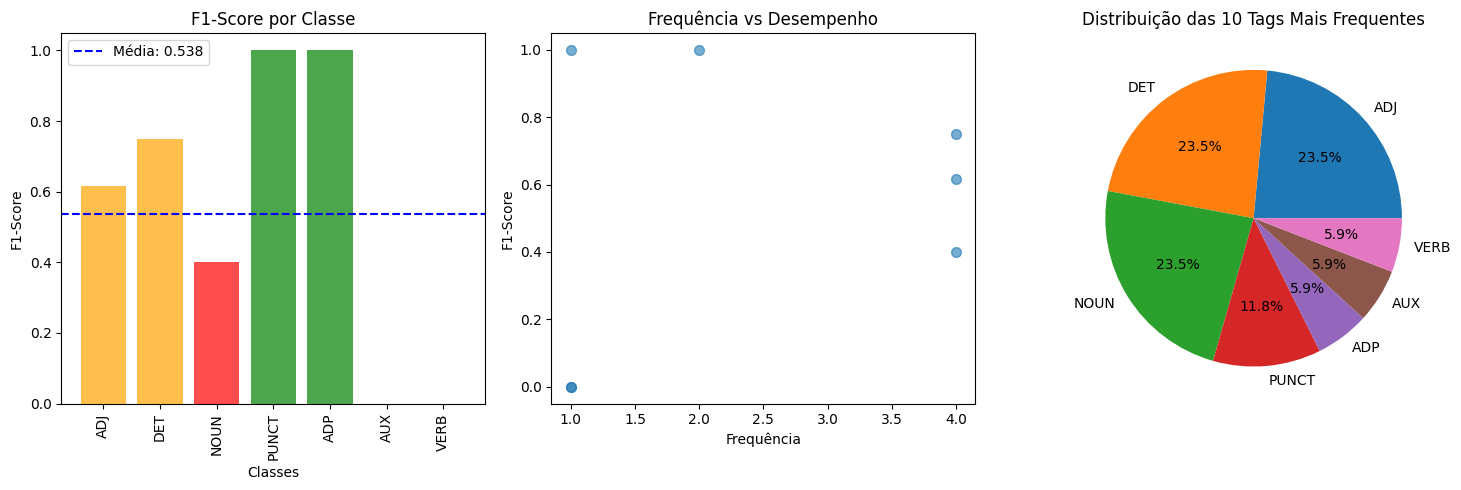


📈 ESTATÍSTICAS FINAIS:
Acurácia Geral: 0.6471
F1-Score Médio: 0.5379
Correlação Frequência-Desempenho: 0.239

🎯 MELHOR CLASSE: PUNCT (F1=1.000)
🎯 PIOR CLASSE: AUX (F1=0.000)

🔍 EXEMPLOS DE PREDIÇÕES:

Exemplo 1:
Verdadeiro: DET ADJ ADJ NOUN VERB ADP DET ADJ...
Predito:    DET ADJ ADJ ADJ ADJ ADP DET ADJ...
Acurácia: 7/10 (0.70)

Exemplo 2:
Verdadeiro: DET AUX DET ADJ NOUN NOUN PUNCT...
Predito:    ADJ DET DET ADJ NOUN ADJ PUNCT...
Acurácia: 4/7 (0.57)

💾 Resultados salvos em 'pos_tagging_final_results.json'
✅ ANÁLISE COMPLETA CONCLUÍDA!


In [ ]:
# Fazer predições
print("Gerando predições...")
try:
    predictions = trainer.predict(tokenized_datasets["validation"])
    preds = np.argmax(predictions.predictions, axis=2)
except:
    # Usar subconjunto pequeno se falhar
    small_data = tokenized_datasets["validation"].select(range(min(10, len(tokenized_datasets["validation"]))))
    predictions = trainer.predict(small_data)
    preds = np.argmax(predictions.predictions, axis=2)

# Processar predições
true_predictions = [
    [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(preds, predictions.label_ids)
]
true_labels = [
    [id2tag[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(preds, predictions.label_ids)
]

flat_predictions = [item for sublist in true_predictions for item in sublist]
flat_labels = [item for sublist in true_labels for item in sublist]

# %%
# Análise detalhada
print("\n" + "="*50)
print("ANÁLISE DOS RESULTADOS")
print("="*50)

# Relatório de classificação
class_report = classification_report(
    flat_labels, flat_predictions, output_dict=True, zero_division=0
)

# Converter para DataFrame
report_df = pd.DataFrame(class_report).transpose()
report_df = report_df[report_df.index.isin(tag2id.keys())]
report_df = report_df.sort_values('support', ascending=False)

print("\n DESEMPENHO POR CLASSE GRAMATICAL:")
print(report_df[['precision', 'recall', 'f1-score', 'support']].head(10))

# %%
# Identificar melhores e piores
best_f1 = report_df.nlargest(5, 'f1-score')[['f1-score', 'support']]
worst_f1 = report_df.nsmallest(5, 'f1-score')[['f1-score', 'support']]

print("\n MELHORES CLASSES:")
print(best_f1)

print("\n  PIORES CLASSES:")
print(worst_f1)

# %%
# Visualizações
plt.figure(figsize=(15, 5))

# Gráfico 1: F1-score por classe
plt.subplot(1, 3, 1)
colors = ['green' if x > 0.8 else 'orange' if x > 0.6 else 'red' for x in report_df['f1-score']]
plt.bar(range(len(report_df)), report_df['f1-score'].values, color=colors, alpha=0.7)
plt.axhline(y=report_df['f1-score'].mean(), color='blue', linestyle='--', label=f'Média: {report_df["f1-score"].mean():.3f}')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('F1-Score por Classe')
plt.xticks(range(len(report_df)), report_df.index, rotation=90)
plt.legend()

# Gráfico 2: Frequência vs Desempenho
plt.subplot(1, 3, 2)
plt.scatter(report_df['support'], report_df['f1-score'], alpha=0.6, s=50)
plt.xlabel('Frequência')
plt.ylabel('F1-Score')
plt.title('Frequência vs Desempenho')

# Gráfico 3: Distribuição de tags
plt.subplot(1, 3, 3)
top_10_tags = report_df.head(10)
plt.pie(top_10_tags['support'], labels=top_10_tags.index, autopct='%1.1f%%')
plt.title('Distribuição das 10 Tags Mais Frequentes')

plt.tight_layout()
plt.show()

# %%
# Estatísticas finais
accuracy = accuracy_score(flat_labels, flat_predictions)
correlation = report_df['support'].corr(report_df['f1-score'])

print("\n ESTATÍSTICAS FINAIS:")
print(f"Acurácia Geral: {accuracy:.4f}")
print(f"F1-Score Médio: {report_df['f1-score'].mean():.4f}")
print(f"Correlação Frequência-Desempenho: {correlation:.3f}")

print(f"\n MELHOR CLASSE: {best_f1.index[0]} (F1={best_f1.iloc[0]['f1-score']:.3f})")
print(f" PIOR CLASSE: {worst_f1.index[0]} (F1={worst_f1.iloc[0]['f1-score']:.3f})")

# %%
# Exemplos de predições
print("\n🔍 EXEMPLOS DE PREDIÇÕES:")
for i in range(min(3, len(true_predictions))):
    print(f"\nExemplo {i+1}:")
    print(f"Verdadeiro: {' '.join(true_labels[i][:8])}...")
    print(f"Predito:    {' '.join(true_predictions[i][:8])}...")
    correct = sum(1 for t, p in zip(true_labels[i], true_predictions[i]) if t == p)
    total = len(true_labels[i])
    print(f"Acurácia: {correct}/{total} ({correct/total:.2f})")

# %%
# Salvar resultados
results = {
    'accuracy': accuracy,
    'f1_mean': float(report_df['f1-score'].mean()),
    'correlation': float(correlation),
    'best_classes': best_f1.to_dict(),
    'worst_classes': worst_f1.to_dict(),
    'all_classes': report_df[['precision', 'recall', 'f1-score', 'support']].to_dict()
}

with open('pos_tagging_final_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n Resultados salvos em 'pos_tagging_final_results.json'")
print("ANÁLISE COMPLETA CONCLUÍDA!")